<a href="https://colab.research.google.com/github/ayush-kumar-rai/SEVEN7CODE-TECHNOLOGIES/blob/mall-customer-segmentation/Mall_Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn import set_config

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

In [36]:
customer_df = pd.read_csv('/content/Mall_Customers.csv')

customer_df = customer_df.drop('CustomerID', axis=1)
customer_df = customer_df.rename(index=str, columns={'Annual Income (k$)': 'Income','Spending Score (1-100)': 'SpendingScore'})

## Mall Customer Segmentation


Perform EDA and find the hidden customer spending patterns in the dataset.

# Dataset Overview

In [37]:
customer_df.shape

(200, 4)

In [38]:
customer_df.dtypes



Gender           object
Age               int64
Income            int64
SpendingScore     int64
dtype: object

In [39]:
customer_df.describe().T


,count,mean,std,min,25%,50%,75%,max
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.0,70.0
Income,200.0,60.56,26.264721,15.0,41.50,61.5,78.0,137.0
SpendingScore,200.0,50.20,25.823522,1.0,34.75,50.0,73.0,99.0


In [40]:
customer_df.isnull().sum()

Gender           0
Age              0
Income           0
SpendingScore    0
dtype: int64

In [41]:
customer_df.head()

,Gender,Age,Income,SpendingScore
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


#EDA

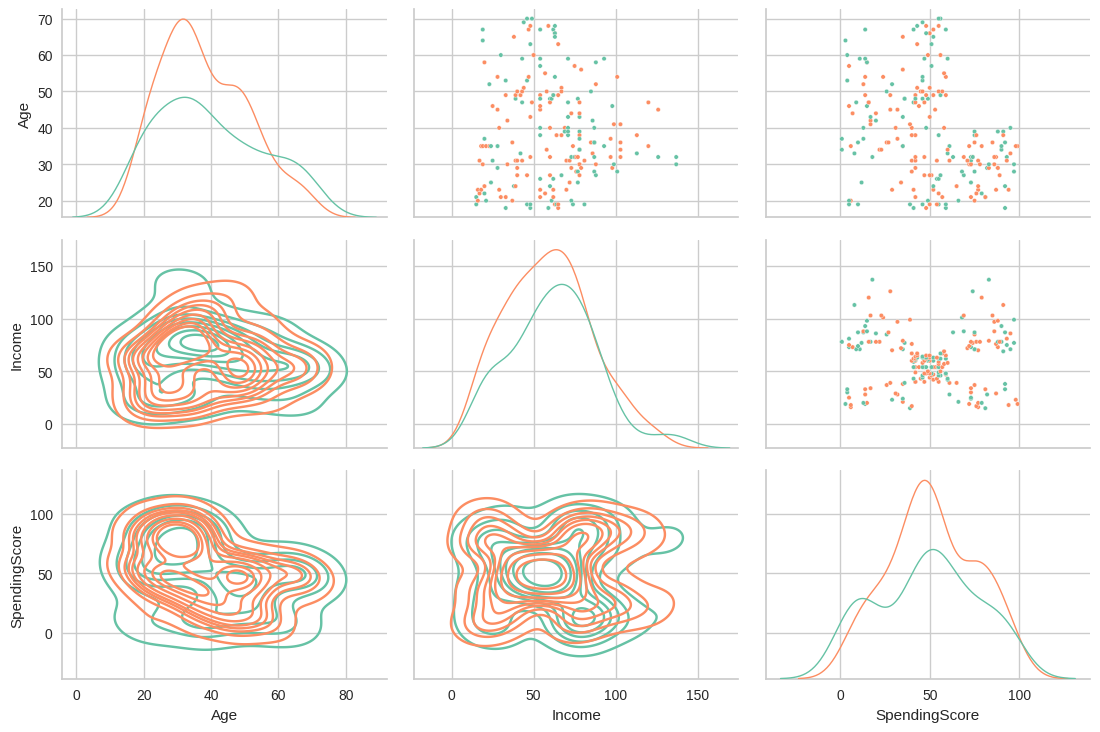

In [42]:
grid = sns.PairGrid(customer_df, hue='Gender', diag_sharey=False, aspect=1.5)

grid.map_upper(sns.scatterplot, s=10)
grid.map_lower(sns.kdeplot)
grid.map_diag(sns.kdeplot, lw=1);

Insights:

Age, Income and Spending Score features are multimodal distributions each having two or three heels
Annual Income and Spending Score plot seems to be formed with a five dense regions: 4 regions are on the sides and one is in the center

##Customer Profile

###Gender

In [43]:
Ratio = px.pie( data_frame=customer_df, names='Gender', color_discrete_sequence=px.colors.qualitative.Set2)
Ratio.show()

Insights:



*   Female customers are on 6% more then males. Virtually even distribution




In [44]:
customer_df[['Age', 'Income']].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.0,70.0
Income,200.0,60.56,26.264721,15.0,41.50,61.5,78.0,137.0


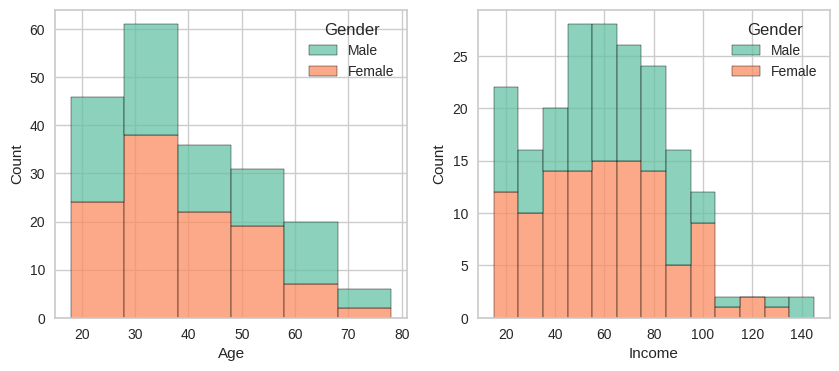

In [45]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(data=customer_df, x='Age', hue='Gender', binwidth=10, multiple='stack', ax=ax0)
sns.histplot(data=customer_df, x='Income', hue='Gender', binwidth=10, multiple='stack', ax=ax1);


Insights:



*   20-30, 30-40 are the most common ages groups among customers

*  The biggest cusomer age group is 30 year-old customers (mostly women)

*  Most of customers earn between 50k-
80k annually
*  Big part of customers earn only $20k annually



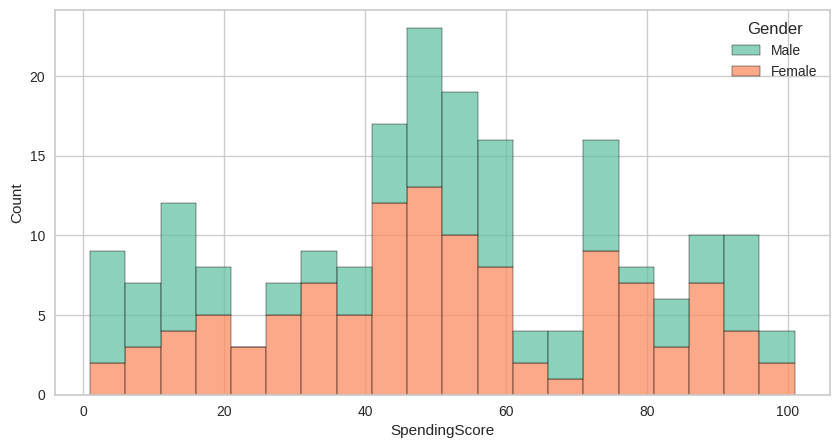

In [46]:
plt.figure(figsize=(10, 5))
sns.histplot(data=customer_df, x='SpendingScore', hue='Gender', binwidth=5, multiple='stack');

Insights:

Spending scores have a few modes:
* between 0 and 20 (men domintate)
* between 25 and 40 (women domintate)
* between 45 and 60 (women domintate)
* between 65 and 70 (men dominates)
* between 70 and 100 (mostly women dominates)

# Spending Score

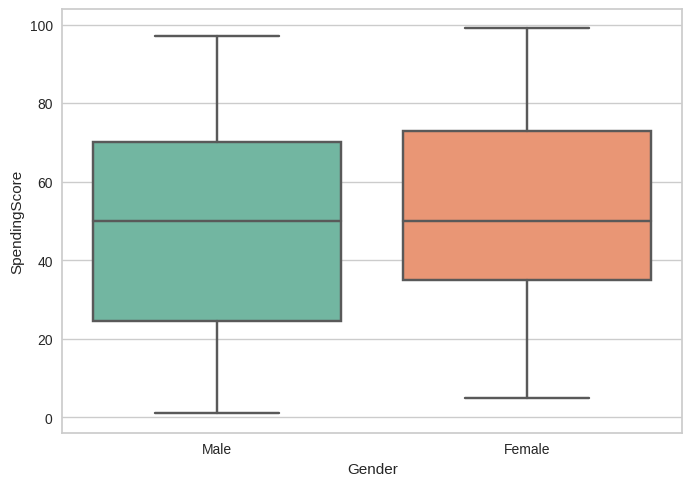

In [47]:
sns.boxplot(data=customer_df, x='Gender', y='SpendingScore');

Insights:

* Women tend to spend more as we see from the bottom bar bound
* On average, women just spend slightly more then men

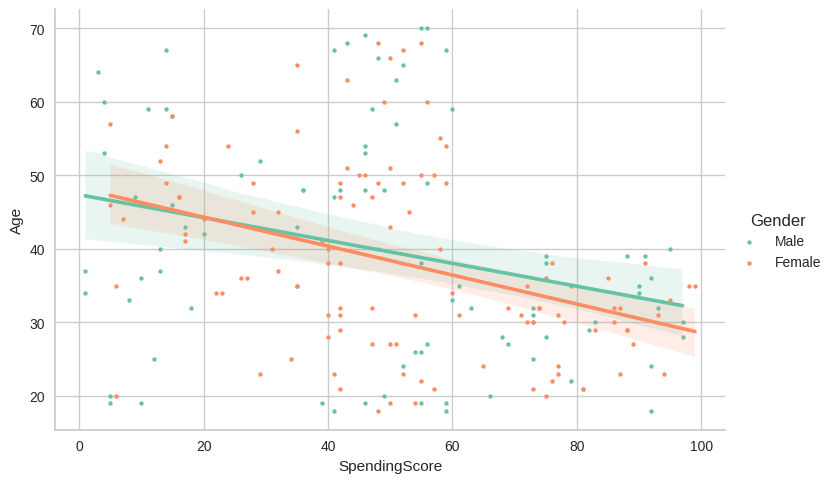

In [48]:
sns.lmplot(data=customer_df, x='SpendingScore', y='Age', hue='Gender', aspect=1.5, scatter_kws={'s': 10, 'alpha': 1});

Insights:

* There is a linear dependency between Spending Score and Age. Younger customers tend to have higher spending score and spending score decreases when age goes up.
* Introducting Spending Groups can help to reveal more insights. So let's introduce three spending groups:



In [49]:
def impute_spending_group(spending_score):
    if spending_score <= 35:
        return 'low'
    if spending_score > 35 and spending_score <= 65:
        return 'medium'
    if spending_score > 65:
        return 'high'

customer_df['SpendingGroup'] = customer_df['SpendingScore'].apply(impute_spending_group)

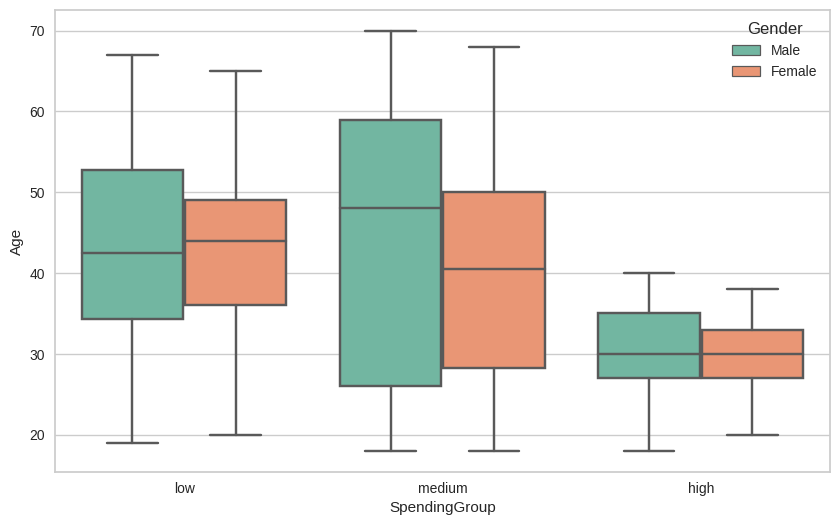

In [50]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=customer_df, x='SpendingGroup', y='Age', hue='Gender', order=['low', 'medium', 'high']);

Insights:

* From the Spending Group - Age plot we can see that the lowest variation is in high spending group. Its members are in 20-40 age group. Low and medium spending groups seem to roughly covers the whole age range.

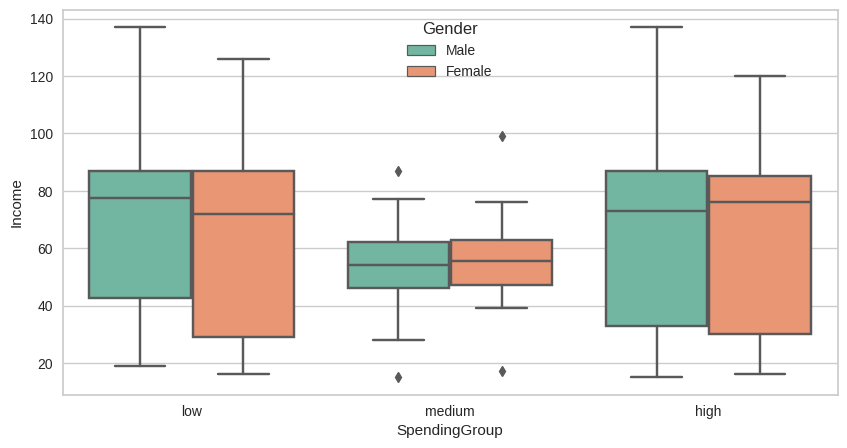

In [51]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=customer_df, x='SpendingGroup', y='Income', hue='Gender', order=['low', 'medium', 'high']);

Insights:

* From the Spending Group - Annual Income plot we can see that customers from the center of the annual income distribution (40k-60k) belongs to medium spending group

Let's give a deeper look at the Annual Income and Spending Score relations:

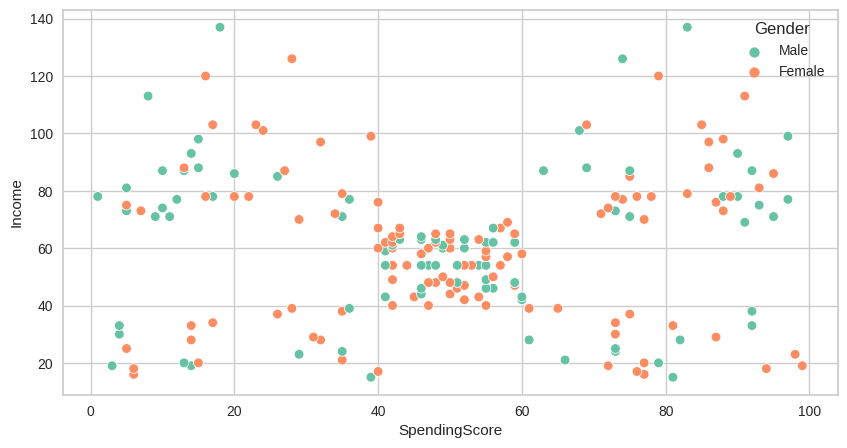

In [52]:
plt.figure(figsize=(10, 5))

sns.scatterplot(data=customer_df, x='SpendingScore', y='Income', hue='Gender');

Insights:

Five visually recognizable clusters seem to be represent customers that have:
>high income and low spending score  
>low income and low spending score  
>high income and low spending score  
>high income and high spending score  
>dense middle cluster with middle income and middle spending score

# Clustering
We are going to try a few clustering models in the next sections but for now we need to preprocess our data set in order to proceed.

# Data Processing
Let's build a data processing pipeline and generate an input for unsupervised models:

In [53]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

In [54]:
data_processor = Pipeline([
    ('processing', ColumnTransformer([
            ('gender_encoder', OrdinalEncoder(), ['Gender']),
            ('spending_group_encoder', OrdinalEncoder(categories=[['low', 'medium', 'high']]), ['SpendingGroup']),
        ], remainder='passthrough')
    )
])

data_processor

Pipeline(steps=[('processing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('gender_encoder',
                                                  OrdinalEncoder(),
                                                  ['Gender']),
                                                 ('spending_group_encoder',
                                                  OrdinalEncoder(categories=[['low',
                                                                              'medium',
                                                                              'high']]),
                                                  ['SpendingGroup'])]))])

In [55]:
X = data_processor.fit_transform(customer_df)

# K-Mean
Reasonably good default for clustering tasks is K-means algorithm.

It works best when there is similar distances from centroids to cluster members. This implies that clusters should have circle-like shape.

From the first glance this doesn't seem to be a case, so we can expect some amount of missclustered customers near cluster boundries.

To use K-means model, we need to know how many clusters are in the dataset. Although visually it's clear that there is five clusters, we won't content with just this and will use the elbow method and silhouette diagram as additional clues.

In [56]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

sns.set_palette('Set2')
set_config(display='diagram')

heatcmap = sns.diverging_palette(230, 20, as_cmap=True)

In [57]:
from sklearn.cluster import KMeans

kmean_model = KMeans(random_state=RANDOM_SEED)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

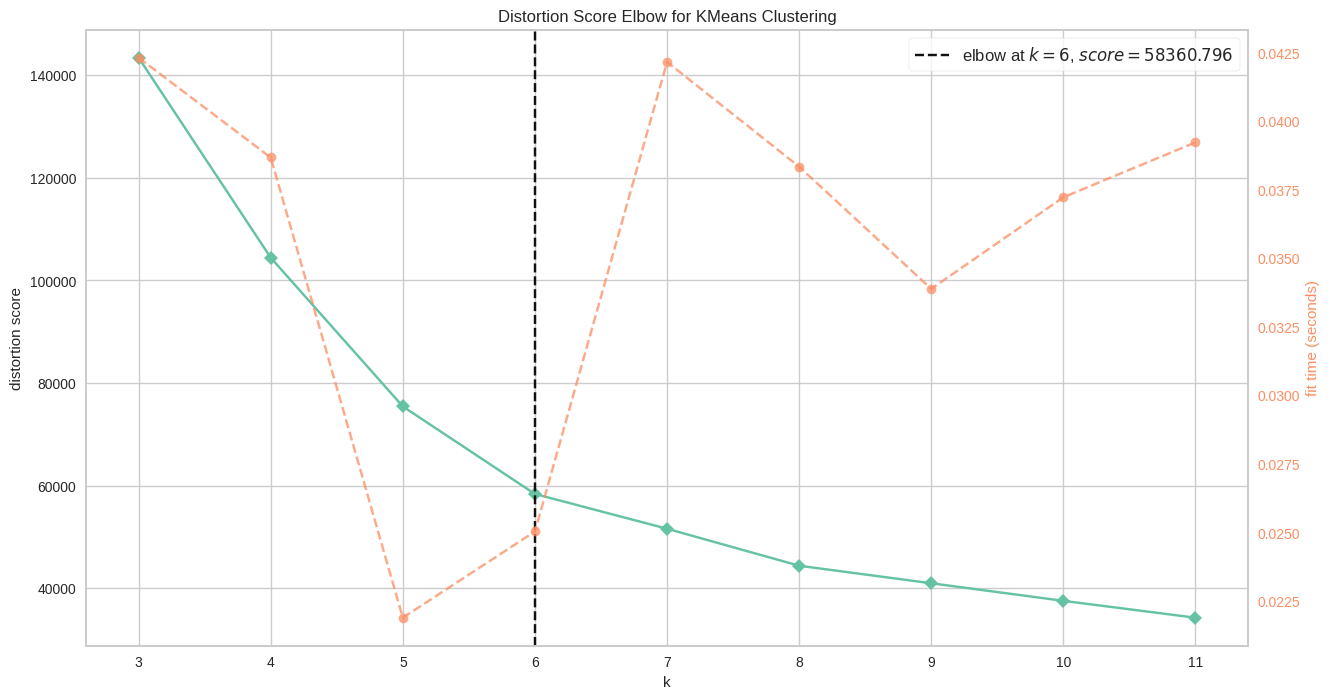

In [58]:
plt.figure(figsize=(15, 8))

elbow_visualizer = KElbowVisualizer(kmean_model, k=(3, 12))

elbow_visualizer.fit(X)
elbow_visualizer.show();

Elbow method suggests to use 6 clusters rather then 5 which we assumed in the beggining. This may be correct because we looked at the two dimentional simplification of the dataset (SpendingScore-Income plot) while we have 4 dimetions in total. In more dimentional space there may be actually more distinct clusters.

Now let's plot silhouette diagrams. We are going to discover [5, 6, 8] range of possible cluster numbers in order to double check that 6 is a good cluster number to go.

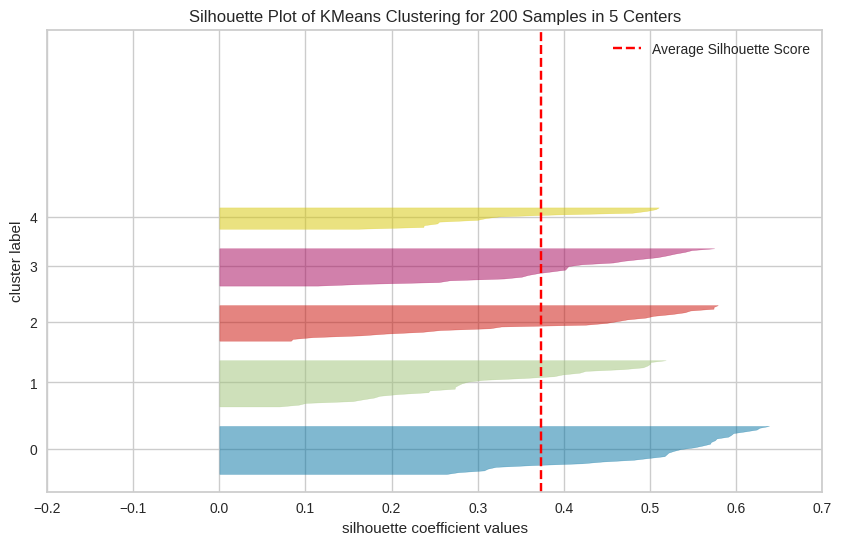

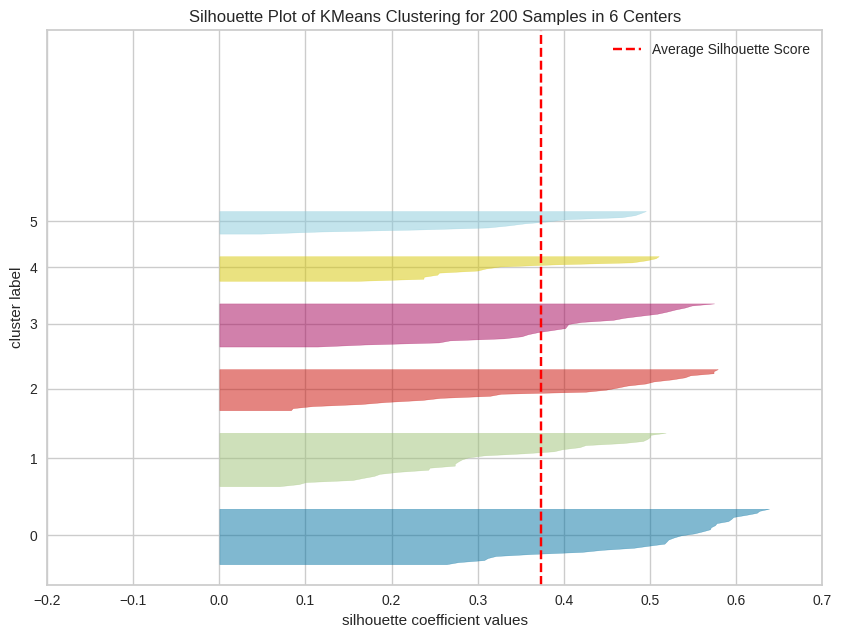

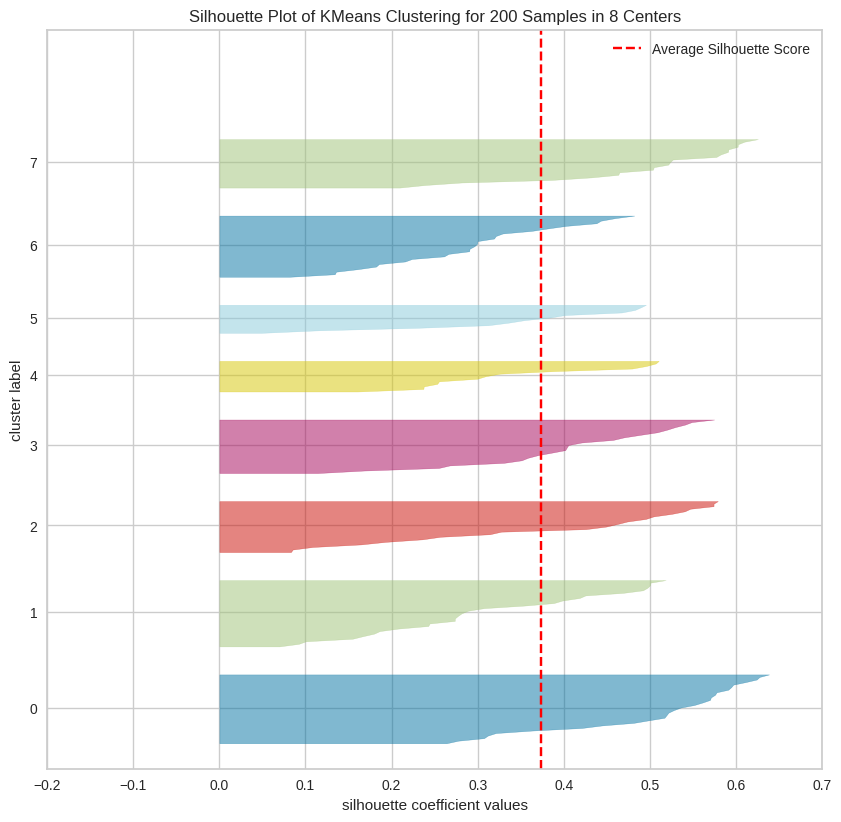

In [59]:
for idx, n_clusters in enumerate([5, 6, 8]):
    plt.figure(figsize=(10, n_clusters * 1.2))

    kmean_model.n_clusters = n_clusters
    silhouette_visualizer = SilhouetteVisualizer(kmean_model, colors='yellowbrick')

    silhouette_visualizer.fit(X);
    silhouette_visualizer.show();


Silhouette diagrams incorporate more information than the elbow plot. Each "blade" on the diagram represents a separate cluster. Height of blades represents number of samples inside of the cluster and width represents strength of inter-cluster connections.

Our goal will be to find clusters of near the same size (heights are nearly the same) which are strongly connected (width is close to the right side of the plot).




Now taking a look at the plots we made for 5, 6, 8 clusters we can see that they are nearly the same in terms of inter-cluster connectivity and size. On the 8 cluster diagram there is one more strongly connected cluster 7 which is absent on the other plots. Let's take it as a sign of slightly better cluster quality. In a worse case we would get a little bit granual clusters which we would be able to merge according to marketing needs.





During experiments, I have tried to go beyond 8 clusters, but higher cluster diagrams doesn't seem to optimal. Some clusters showed negative silhouette score which is sign of sample misclustering. Also, given dataset contains only 4 features which limits possible clustering. For instance, when number of clusters more then 10, silhouette diagram starts to show empty clusters.




In SpendingScore-Income space, 8 clusters look like this:

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



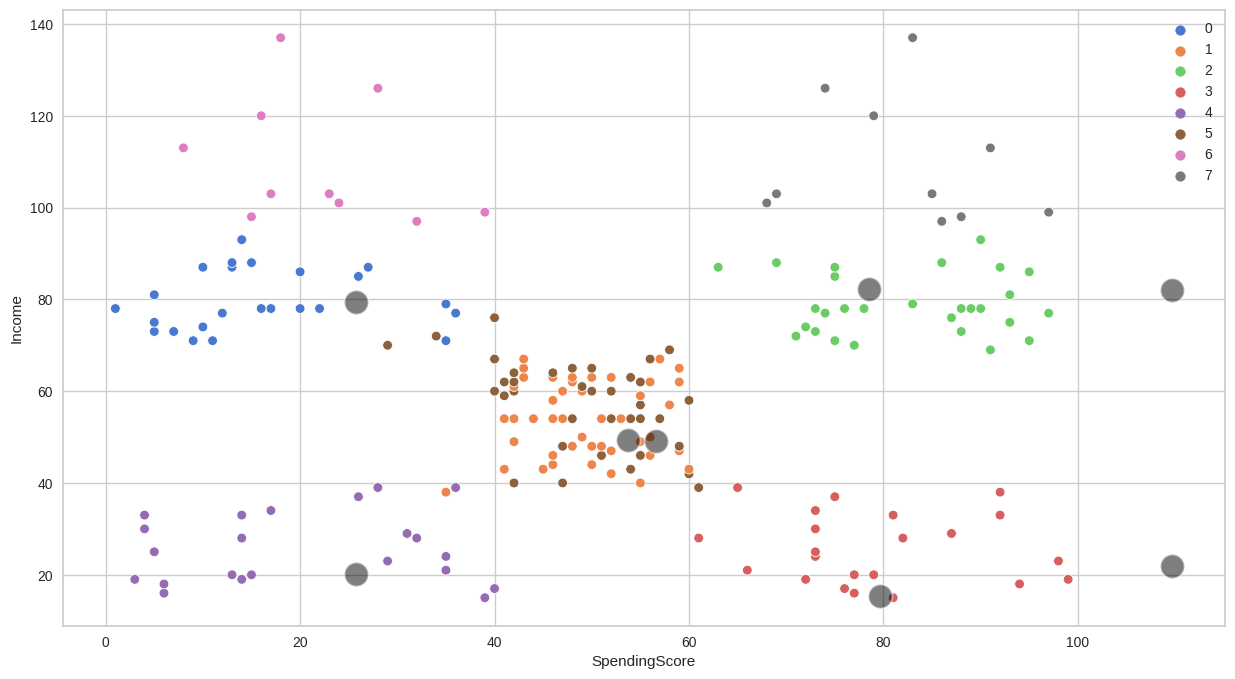

In [60]:
kmean_model.n_clusters = 8
kmean_model.fit(X)

kmean_clusters = kmean_model.labels_
kmean_centroids = kmean_model.cluster_centers_

plt.figure(figsize=(15, 8))

sns.scatterplot(data=customer_df, x='SpendingScore', y='Income', hue=kmean_clusters, palette='muted');
sns.scatterplot(x=kmean_centroids[:, 3], y=kmean_centroids[:, 4], color='black', s=300, alpha=0.5);

Evidently, 2d space is not enough to distantly show all 8 clusters. We will explore them in higher dimentinal space further in this notebook.



# **Cluster Analysis**
Let's reproduce K-means clustering with 8 clusters for further exploring:

In [61]:
kmean_model = KMeans(n_clusters=8, random_state=RANDOM_SEED)

kmean_model.fit(X)

kmean_clusters = kmean_model.labels_
kmean_centroids = kmean_model.cluster_centers_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [62]:
customer_df['Cluster'] = kmean_clusters

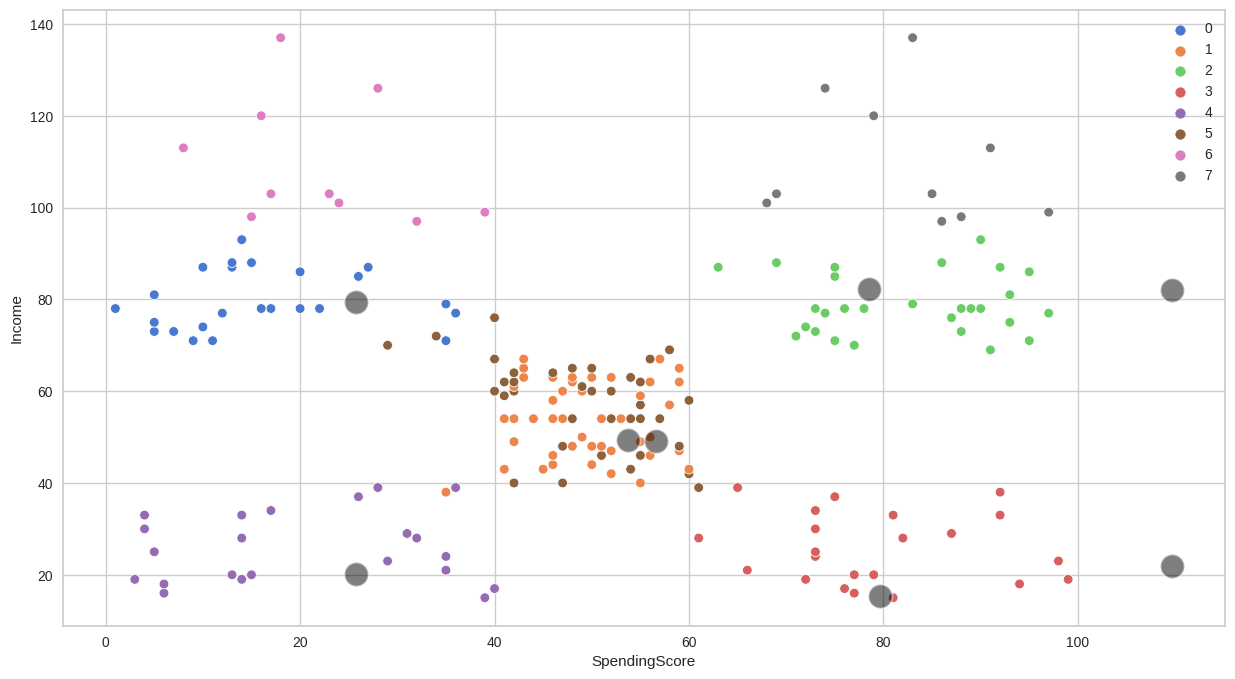

In [63]:
plt.figure(figsize=(15, 8))

sns.scatterplot(data=customer_df, x='SpendingScore', y='Income', hue='Cluster', palette='muted');
sns.scatterplot(x=kmean_centroids[:, 3], y=kmean_centroids[:, 4], color='black', s=300, alpha=0.5);

**2d** space limits us and we need to go into 3d space in order to get a grasp of our clusters:


In [67]:
import plotly.express as px

fig = px.scatter_3d(customer_df,x='Age',y='SpendingScore',z='Income', color=kmean_clusters.astype(str), opacity=0.8, height=700, width=700, title='Clusters in Age-SpendingScore-Income space',color_discrete_sequence=px.colors.qualitative.Set2)
fig.show()

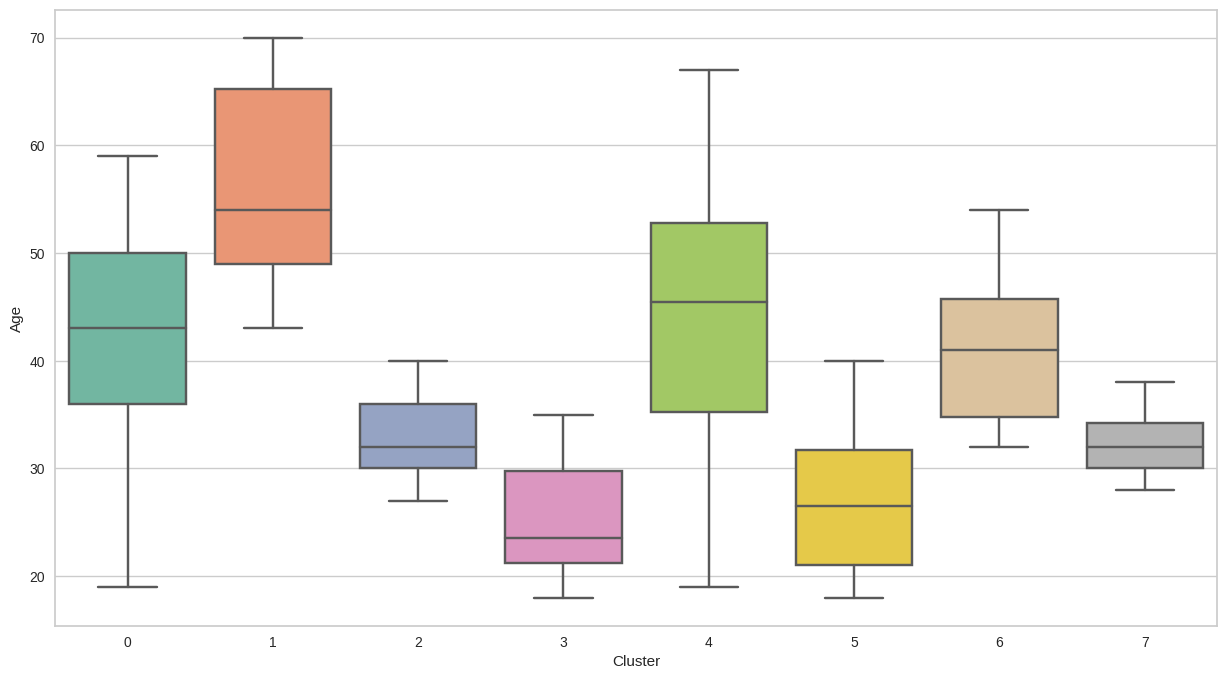

In [65]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=customer_df, x='Cluster', y='Age');


Age-SpendingScore-Income plot does a good job in distincting our clusters.




Just by looking at this 3d plot, we can see the following insights about clusters:

Cluster 0 - Low Spending Score, Upper-middle Income, Middle Age

Cluster 1 - Middle Spending Score, Middle Income, Old Age

Cluster 2 - High Spending Score, Upper-middle income, Middle Age

Cluster 3 - High Spending Score, Low Income, Young Age

Cluster 4 - Low Spending Score, Low Income, All Age

Cluster 5 - Middle Spending Score, Middle Income, Young Age

Cluster 6 - Low Spending Score, High Income, Middle Age

Cluster 7 - High Spending Score, High Income, Middle Age


Gender-SpendingScore-Income plot also was tried but it doesn't bring much information which means that gender is not significant factor for given dataset.



Let's visually represent the same insights in kind of summary heatmap:


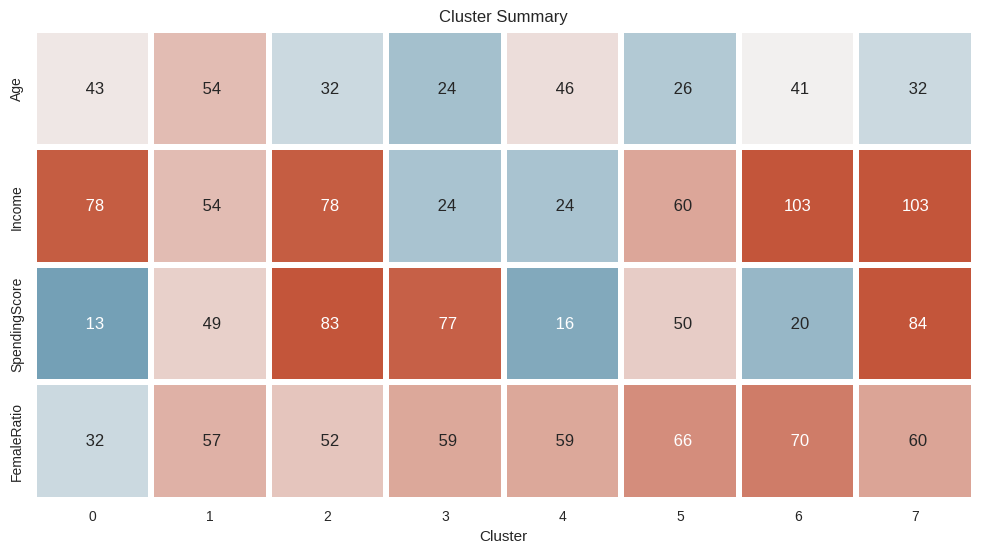

In [66]:
cluster_heatmap_df = customer_df.groupby(['Cluster'])[['Age', 'Income', 'SpendingScore']].median()
cluster_heatmap_df['FemaleRatio'] = customer_df[customer_df['Gender'] == 'Female'].groupby(['Cluster']).count()['Gender'] / customer_df.groupby(['Cluster']).count()['Gender'] * 100

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

sns.heatmap(cluster_heatmap_df.T,square=True,linewidth=3,vmax=80,vmin=1,cmap=heatcmap,cbar=False,annot=True,fmt='3.0f',ax=ax,);

ax.set_title('Cluster Summary');
plt.tight_layout()

Summary heat map contains Female Ratio column. Generally, we have slightly more females in the dataset (44% / 56%). However, we see that the same distribution is not necessarily preserved in all clusters:

Cluster 0 consists of males
Cluster 5 and Cluster 6 have much more females then the whole distribution
The rest of the clusters have just little diviations from the whole distribution

# Marketing Insights
Now when we have described founded customer clusters, it's time to suggest useful actions. We will go cluster by cluster and see how can we improve customer spending scores:

# Cluster 0 (Low Spending Score, Upper-middle Income, All Ages, 68% Males)
This cluster has a great potential because income level is higher then the average income. Most customers in this segment are males which is not common for the dataset. We suggest to take a look at product line that males potentially could buy for themselves, their partners and children. High-end products can be included for this segment.

#Cluster 1 (Middle Spending Score, Middle Income, Old Age, 57% Females)
This cluster is one of the middle segments with respect to income/spending. The cluster consists of males and females with little dominance of latter (by 7%). The segment is already intrested in purchases from the mall and probably have a list of regular products they tend to buy. Analysing those products could help to perform cross-selling of related products as well as offering occasionally high-end upsells.

#Cluster 2 (High Spending Score, Upper-middle income, Middle Age, 52% Females)
This is one of the most profitable segments. This segment contains almost the same distribution of males and females. High-end general purpose products are good stuff to promote in the segment.

#Cluster 3 (High Spending Score, Low Income, Young Ages, 59% Females)
Customers from this segment have already showed a good spending activity, but they most likely limited in terms of budget. They may be good candidates for promotion/coupon campaigns. In worse case, they would not increase their spendings.

#Cluster 4 (Low Spending Score, Low Income, All Ages, 59% Females)
This segment includes customers with low spending score and low income across all ages. There are slightly more women. Customers from this cluster would be happy to save money. Including them to any kind of promotion lists or providing accumulation accounts may help to increase purchase activities.

#Cluster 5 (Middle Spending Score, Middle Income, Young Age, 66% Females)
This is a counterpart of Cluster 1 with a larger percentage of females and younger ages. This segment has a good potetial, so deals that include tranding stuff for young female audiance may help to increase spendings of the segment.

#Cluster 6 (Low Spending Score, High Income, Middle Ages, 70% Females)
This segment is similar to Cluster 0, but with mostly female audience. Hence, suggestion is the same but with main focus on female's needs.

#Cluster 7 (High Spending Score, High Income, Middle Ages, 60% Females)
This is one of the most profitable segments. Offering high-end female-focus products may help to keep them spend.



# Summary
We performed EDA and clustering on a small mall customer dataset.

We picked to find 8 clusters and performed their analysis. It was also possible to pick 5 or 6 clusters, but we chose to be more specific that that.

For each cluster we found an average customer represented in given dataset features. Based on customer portrait, we suggested general marketing advice on how the mall may target each customer cluster. To sum up this, we found potential in the current customer dataset which may be exploit by marketing team and cluster-specific targeting of customer needs.

